Interest rate prediction based on available features using RandomForestRegressor, Ridge regressor and SVR

In [52]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

Get the data ready

In [53]:
# Import the dataset
from google.colab import files
uploaded = files.upload()

Saving Loan data.csv to Loan data (1).csv


In [54]:
df=pd.read_csv("Loan data.csv")

In [55]:
# View the data
df.head(3)

,ID,Amount.Requested,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length
0,81174.0,20000,8.90%,36 months,debt_consolidation,14.90%,SC,MORTGAGE,6541.67,735-739,14,14272,2.0,< 1 year
1,99592.0,19200,12.12%,36 months,debt_consolidation,28.36%,TX,MORTGAGE,4583.33,715-719,12,11140,1.0,2 years
2,80059.0,35000,21.98%,60 months,debt_consolidation,23.81%,CA,MORTGAGE,NaN,690-694,14,21977,1.0,2 years


In [56]:
# View the data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              2499 non-null   float64
 1   Amount.Requested                2499 non-null   object 
 2   Interest.Rate                   2500 non-null   object 
 3   Loan.Length                     2499 non-null   object 
 4   Loan.Purpose                    2499 non-null   object 
 5   Debt.To.Income.Ratio            2499 non-null   object 
 6   State                           2499 non-null   object 
 7   Home.Ownership                  2499 non-null   object 
 8   Monthly.Income                  2491 non-null   float64
 9   FICO.Range                      2500 non-null   object 
 10  Open.CREDIT.Lines               2496 non-null   object 
 11  Revolving.CREDIT.Balance        2494 non-null   object 
 12  Inquiries.in.the.Last.6.Months  24

In [58]:
df.columns

Index(['ID', 'Amount.Requested', 'Interest.Rate', 'Loan.Length',
       'Loan.Purpose', 'Debt.To.Income.Ratio', 'State', 'Home.Ownership',
       'Monthly.Income', 'FICO.Range', 'Open.CREDIT.Lines',
       'Revolving.CREDIT.Balance', 'Inquiries.in.the.Last.6.Months',
       'Employment.Length'],
      dtype='object')

In [59]:
# Analyze the purpose of the loan
df['Loan.Purpose'].value_counts()*100/len(df)

# Observations: over 52% of the loans are taken for debt consolidation and 18% for credit card bill payment

debt_consolidation    52.28
credit_card           17.76
other                  8.00
home_improvement       6.08
major_purchase         4.04
small_business         3.48
car                    2.00
wedding                1.56
medical                1.20
moving                 1.16
vacation               0.84
house                  0.80
educational            0.60
renewable_energy       0.16
Name: Loan.Purpose, dtype: float64

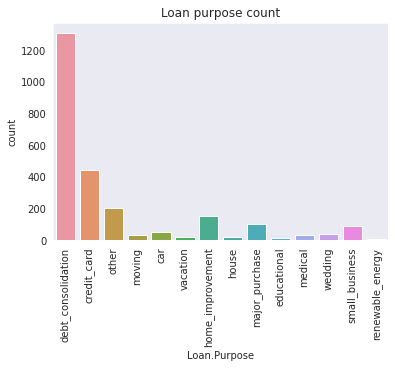

In [60]:
import seaborn as sns
sns.countplot(x='Loan.Purpose', data=df)
plt.title("Loan purpose count")
plt.xticks(rotation=90);

Cleaning the dataset

In [61]:
df['Debt.To.Income.Ratio'] = df['Debt.To.Income.Ratio'].str.rstrip('%') # remove the special characters from the data (%)
df['Interest.Rate'] = df['Interest.Rate'].str.rstrip('%') # remove the special characters from the data (%)
df['Loan.Length'] = df['Loan.Length'].str.extract('(\d+)',expand=False) # remove the string (months)


In [62]:
# Replacing the employment length with 10+years as 10 and <1y yr as 0
mapping_dict = {
    "Employment.Length":{
        "10+ years": 10,
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0
    }
}
df = df.replace(mapping_dict)
df['Employment.Length'].head() 


0    0
1    2
2    2
3    5
4    9
Name: Employment.Length, dtype: object


FICO scores are generally credit scores issued by banks, rather than focussing on the high and low range, average FICO score has been generated for each ID.



In [63]:
#FICO scores are generally credit scores issued by banks, rather than focussing on the high and low range, the average FICO score is generated for each applicant
# Splitting the FICO range into high and low
df[['FICO_low', 'FICO_high']] = df['FICO.Range'].str.split('-', 1, expand=True)

In [64]:
# Drop the original column
df=df.drop(['FICO.Range'], axis=1)


In [65]:
df[['FICO_high']] = df['FICO_high'].astype(float)
df[['FICO_low']] = df['FICO_low'].astype(float)

In [66]:
# Generating the average FICO range
df['FICO.average'] = (df['FICO_high']+df['FICO_low'])/2

In [67]:
drop_columns=['FICO_high','FICO_low']
df = df.drop(drop_columns,axis=1)
df.head(3)

,ID,Amount.Requested,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length,FICO.average
0,81174.0,20000,8.90,36,debt_consolidation,14.90,SC,MORTGAGE,6541.67,14,14272,2.0,0,737.0
1,99592.0,19200,12.12,36,debt_consolidation,28.36,TX,MORTGAGE,4583.33,12,11140,1.0,2,717.0
2,80059.0,35000,21.98,60,debt_consolidation,23.81,CA,MORTGAGE,NaN,14,21977,1.0,2,692.0


In [68]:
df.columns

Index(['ID', 'Amount.Requested', 'Interest.Rate', 'Loan.Length',
       'Loan.Purpose', 'Debt.To.Income.Ratio', 'State', 'Home.Ownership',
       'Monthly.Income', 'Open.CREDIT.Lines', 'Revolving.CREDIT.Balance',
       'Inquiries.in.the.Last.6.Months', 'Employment.Length', 'FICO.average'],
      dtype='object')

As published in the article by Emekter et al., (2014), FICO scores are calculated based on revolving credit balance, debt to income ration, open credit lines, hence dropping the unwanted columns


In [69]:
#Dropping revolving credit balance, debt to income ratio, open credit lines as FICO range is calculated based on these information, droppping ID as it doesnt have impact on the output
drop_columns=['Revolving.CREDIT.Balance','Debt.To.Income.Ratio','Open.CREDIT.Lines','ID']
df = df.drop(drop_columns,axis=1)
df.head(3)

,Amount.Requested,Interest.Rate,Loan.Length,Loan.Purpose,State,Home.Ownership,Monthly.Income,Inquiries.in.the.Last.6.Months,Employment.Length,FICO.average
0,20000,8.90,36,debt_consolidation,SC,MORTGAGE,6541.67,2.0,0,737.0
1,19200,12.12,36,debt_consolidation,TX,MORTGAGE,4583.33,1.0,2,717.0
2,35000,21.98,60,debt_consolidation,CA,MORTGAGE,NaN,1.0,2,692.0


In [71]:
# Replacing the special characters with 0
df['Amount.Requested'] = df ['Amount.Requested'].str.replace('.','0')
df['State'] = df ['State'].str.replace('.','0')


In [72]:
df['Amount.Requested'] = df['Amount.Requested'].astype(float)
df[['Interest.Rate']] = df['Interest.Rate'].astype(float)


In [73]:
# Converting loan length, loan purpose, state, home ownership and employment length as categories 
for label, content in df.items():
  if pd.api.types.is_string_dtype(content):
    df[label]=content.astype("category").cat.as_ordered()

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Amount.Requested                2499 non-null   float64 
 1   Interest.Rate                   2500 non-null   float64 
 2   Loan.Length                     2498 non-null   category
 3   Loan.Purpose                    2499 non-null   category
 4   State                           2499 non-null   category
 5   Home.Ownership                  2499 non-null   category
 6   Monthly.Income                  2491 non-null   float64 
 7   Inquiries.in.the.Last.6.Months  2494 non-null   float64 
 8   Employment.Length               2422 non-null   category
 9   FICO.average                    2499 non-null   float64 
dtypes: category(5), float64(5)
memory usage: 113.0 KB


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


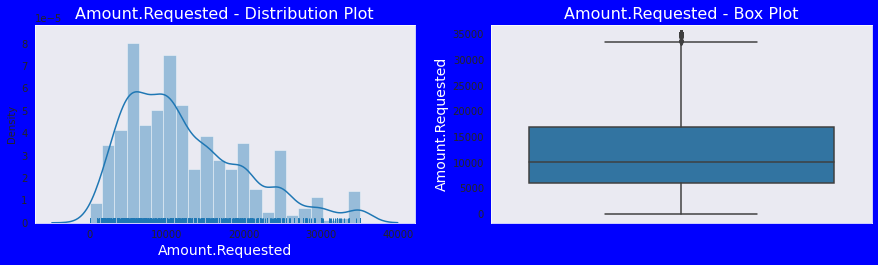

In [75]:
# Univariate analysis on amount requested

plt.figure(figsize=(15,8),facecolor='b')
sns.set_style("dark")
# subplot 1
plt.subplot(2, 2, 1)
ax = sns.distplot(df['Amount.Requested'],rug = True)
ax.set_title('Amount.Requested - Distribution Plot',fontsize=16,color='w')
ax.set_xlabel('Amount.Requested',fontsize=14,color='w')
# subplot 2
plt.subplot(2, 2, 2)
ax = sns.boxplot(y=df['Amount.Requested'])
ax.set_title('Amount.Requested - Box Plot',fontsize=16,color='w')
ax.set_ylabel('Amount.Requested',fontsize=14,color='w')
plt.show()

# Observations: Plots demonstrates that most of the Loan amounts are in range of 6000 - 15000

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


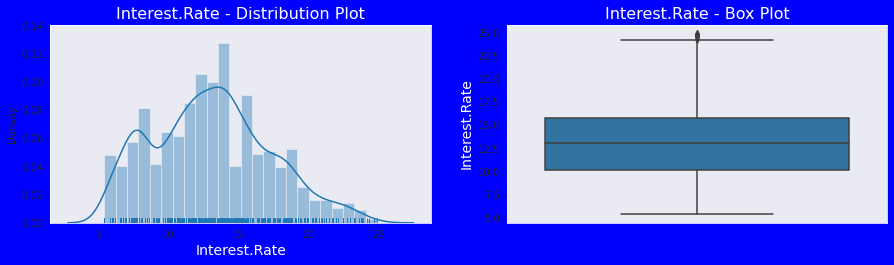

In [76]:
 #Univariate analysis on interest rate

plt.figure(figsize=(15,8),facecolor='b')
sns.set_style("dark")
# subplot 1
plt.subplot(2, 2, 1)
ax = sns.distplot(df['Interest.Rate'],rug = True)
ax.set_title('Interest.Rate - Distribution Plot',fontsize=16,color='w')
ax.set_xlabel('Interest.Rate',fontsize=14,color='w')
# subplot 2
plt.subplot(2, 2, 2)
ax = sns.boxplot(y=df['Interest.Rate'])
ax.set_title('Interest.Rate - Box Plot',fontsize=16,color='w')
ax.set_ylabel('Interest.Rate',fontsize=14,color='w')
plt.show()

# Observations: Plots ilustrates that most of the Interest Rates are in range of 10% - 15%

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


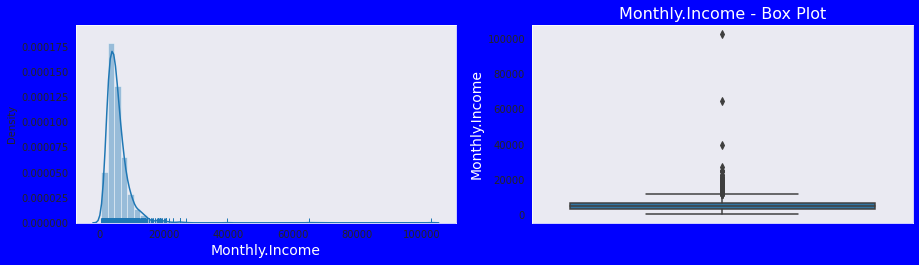

In [77]:
# Univariate analysis on monthly income

plt.figure(figsize=(15,8),facecolor='b')
sns.set_style("dark")
# subplot 1
plt.subplot(2, 2, 1)
ax = sns.distplot(df['Monthly.Income'],rug = True)
ax.set_title('Monthly.Income - Distribution Plot',fontsize=16,color='b')
ax.set_xlabel('Monthly.Income',fontsize=14,color='w')
# subplot 2
plt.subplot(2, 2, 2)
plt.title('Monthly.Income - Box Plot')
ax = sns.boxplot(y=df['Monthly.Income'])
ax.set_title('Monthly.Income - Box Plot',fontsize=16,color='w')
ax.set_ylabel('Monthly.Income',fontsize=14,color='w')
plt.show()

# Observations: plot demonstrates that most of the borrower's monthly incomes are within the range of 0-20000

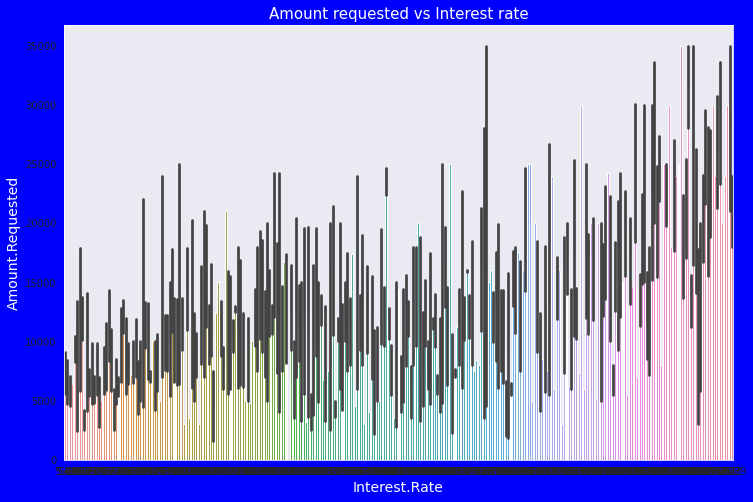

In [78]:
# Amount requested vs interest rate

fig, ax1 = plt.subplots(figsize=(12, 8),facecolor='b')
ax1.set_title('Amount requested vs Interest rate',fontsize=15,color = 'w')
ax1=sns.barplot(x='Interest.Rate', y='Amount.Requested', data=df)
ax1.set_ylabel('Amount.Requested',fontsize=14,color = 'w')
ax1.set_xlabel('Interest.Rate',fontsize=14,color='w')
plt.show()

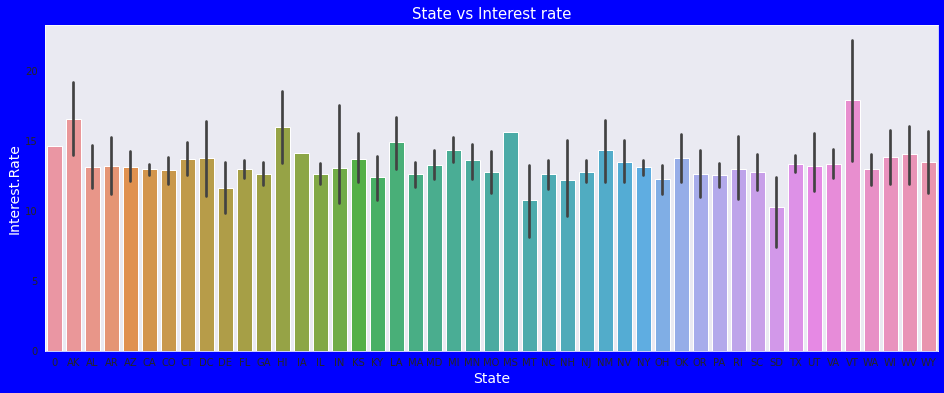

In [79]:
# Lets draw bar plots on state vs interest rate

fig, ax1 = plt.subplots(figsize=(16, 6),facecolor='b')
ax1.set_title('State vs Interest rate',fontsize=15,color='w')
ax1=sns.barplot(x='State', y='Interest.Rate', data=df)
ax1.set_xlabel('State',fontsize=14,color='w')
ax1.set_ylabel('Interest.Rate',fontsize=14,color = 'w')
plt.show()

# Observations: The states such as Vermont, Alaska and Hawai reported to have high interest rate whereas states like Montana, South Dakota have low interest rates

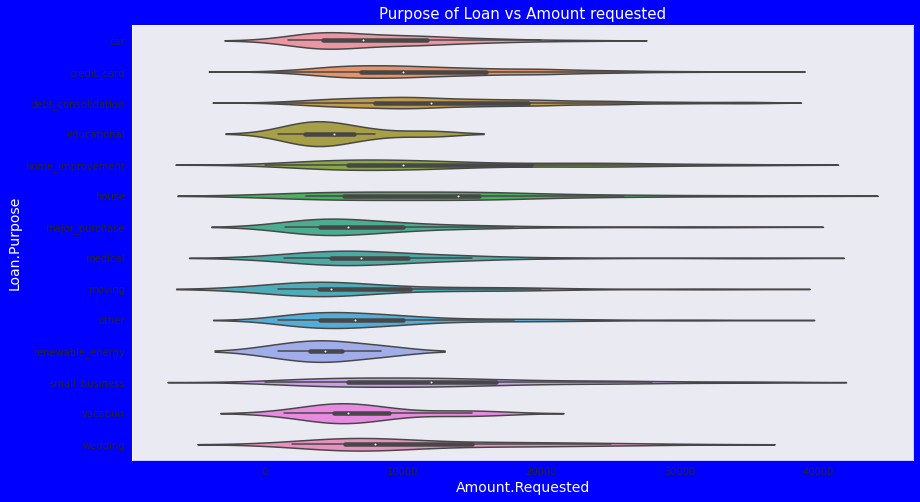

In [80]:
# Bivariate Analysis - purpose of loan vs amount requested

plt.figure(figsize=(14,8),facecolor='b')
ax=sns.violinplot(y='Loan.Purpose', x='Amount.Requested', data =df)
ax.set_title('Purpose of Loan vs Amount requested',fontsize=15,color='w')
ax.set_ylabel('Loan.Purpose',fontsize=14,color = 'w')
ax.set_xlabel('Amount.Requested',fontsize=14,color = 'w')
plt.show()

# Observations: Loan taken for small business, house, debt consolidation and credit card is observed to be evenly distributed


In [81]:
df.head(3)

,Amount.Requested,Interest.Rate,Loan.Length,Loan.Purpose,State,Home.Ownership,Monthly.Income,Inquiries.in.the.Last.6.Months,Employment.Length,FICO.average
0,20000.0,8.90,36,debt_consolidation,SC,MORTGAGE,6541.67,2.0,0,737.0
1,19200.0,12.12,36,debt_consolidation,TX,MORTGAGE,4583.33,1.0,2,717.0
2,35000.0,21.98,60,debt_consolidation,CA,MORTGAGE,NaN,1.0,2,692.0


In [82]:
df.to_csv("pre_procesed.csv", index=False)

In [83]:
df.isnull().sum()

Amount.Requested                   1
Interest.Rate                      0
Loan.Length                        2
Loan.Purpose                       1
State                              1
Home.Ownership                     1
Monthly.Income                     9
Inquiries.in.the.Last.6.Months     6
Employment.Length                 78
FICO.average                       1
dtype: int64

In [84]:
df.isnull().sum()/len(df)

Amount.Requested                  0.0004
Interest.Rate                     0.0000
Loan.Length                       0.0008
Loan.Purpose                      0.0004
State                             0.0004
Home.Ownership                    0.0004
Monthly.Income                    0.0036
Inquiries.in.the.Last.6.Months    0.0024
Employment.Length                 0.0312
FICO.average                      0.0004
dtype: float64

In [85]:
df['Employment.Length'] = df ['Employment.Length'].str.replace('.','0')

Since the missing values are less than 1%, the observations can be dropped, for the purpose of project I have imputed the missing values using simple imputer and predicted using RandomForestRegressor

In [86]:
# Impute the mising values using simple imputer
# Convert categorical into numerical with onehotencoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

df.dropna(subset=["Interest.Rate"], inplace=True)

# Modelling
from sklearn.ensemble import RandomForestRegressor # instantiating randomforest regressor
from sklearn.model_selection import train_test_split

# Setup random seed
import numpy as np
np.random.seed(42)

# Define different features and transformer pipelines
categorical_features = ["Loan.Length", "Loan.Purpose","State","Home.Ownership","Employment.Length"]
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

numeric_features = ["Amount.Requested","Monthly.Income","Inquiries.in.the.Last.6.Months","FICO.average"]
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean"))
])

# Setup preprocessing steps (fill missing values, then convert to numbers)
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numeric_transformer, numeric_features)],
        
        )

# Create a preprocessing and modelling pipeline
model = Pipeline(steps=[("preprocessor", preprocessor),
                        ("model", RandomForestRegressor())])

X = df.drop("Interest.Rate", axis=1)
y = df["Interest.Rate"]
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2)

# Fit the model to the data and use it to make a prediction
model.fit(X_train,y_train)

# Evaluate the model
model.score(X_test, y_test)

0.7744678497333137

# Hyperparameter tunings

In [87]:
# Proceeding with hyperparameter tuning to improve the quality of the model
df = pd.read_csv("pre_procesed.csv")

In [88]:
df.head(5)

,Amount.Requested,Interest.Rate,Loan.Length,Loan.Purpose,State,Home.Ownership,Monthly.Income,Inquiries.in.the.Last.6.Months,Employment.Length,FICO.average
0,20000.0,8.90,36.0,debt_consolidation,SC,MORTGAGE,6541.67,2.0,0,737.0
1,19200.0,12.12,36.0,debt_consolidation,TX,MORTGAGE,4583.33,1.0,2,717.0
2,35000.0,21.98,60.0,debt_consolidation,CA,MORTGAGE,NaN,1.0,2,692.0
3,10000.0,9.99,36.0,debt_consolidation,KS,MORTGAGE,3833.33,0.0,5,697.0
4,12000.0,11.71,36.0,credit_card,NJ,RENT,3195.00,0.0,9,697.0


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Amount.Requested                2499 non-null   float64
 1   Interest.Rate                   2500 non-null   float64
 2   Loan.Length                     2498 non-null   float64
 3   Loan.Purpose                    2499 non-null   object 
 4   State                           2499 non-null   object 
 5   Home.Ownership                  2499 non-null   object 
 6   Monthly.Income                  2491 non-null   float64
 7   Inquiries.in.the.Last.6.Months  2494 non-null   float64
 8   Employment.Length               2422 non-null   object 
 9   FICO.average                    2499 non-null   float64
dtypes: float64(6), object(4)
memory usage: 195.4+ KB


In [90]:
for label, content in df.items():
  if pd.api.types.is_string_dtype(content):
    df[label]=content.astype("category").cat.as_ordered()

In [91]:
# Check missing values in categorical data
for label, content in df.items():
  if pd.api.types.is_categorical_dtype(content):
    if pd.isnull(content).sum():
      print(label)

Loan.Purpose
State
Home.Ownership
Employment.Length


In [92]:
# Fill categorical data
for label, content in df.items():
  if not pd.api.types.is_numeric_dtype(content):
    df[label]=pd.Categorical(content).codes+1

In [93]:
df.isnull().sum()

Amount.Requested                  1
Interest.Rate                     0
Loan.Length                       2
Loan.Purpose                      0
State                             0
Home.Ownership                    0
Monthly.Income                    9
Inquiries.in.the.Last.6.Months    6
Employment.Length                 0
FICO.average                      1
dtype: int64

In [94]:
# drop the remaining observations as it doesnt affect the results
df = df.dropna()

In [95]:
# Make predictions using RandomForestRegressor and estimate using different metrics
X = df.drop("Interest.Rate", axis=1)
y = df["Interest.Rate"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_preds = model.predict(X_test)

# R2
from sklearn.metrics import r2_score
print(r2_score(y_test,y_preds))

# MAE
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test,y_preds))

# MSE
from sklearn.metrics import mean_squared_error
print(mean_absolute_error(y_test,y_preds))

0.7506066753705796
1.5191937625754526
1.5191937625754526


In [96]:
# Cross validation
from sklearn.model_selection import cross_val_score
np.random.seed(42)
for i in range(10, 100, 10):
    print(f"Trying model with {i} estimators...")
    model = RandomForestRegressor(n_estimators=i).fit(X_train, y_train)
    print(f"Model accruacy on test set: {model.score(X_test, y_test)}")
    print(f"Cross-validation score: {np.mean(cross_val_score(model, X, y, cv=5)) * 100}%")
    print("")

Trying model with 10 estimators...
Model accruacy on test set: 0.7310114909524263
Cross-validation score: 76.3910211187248%

Trying model with 20 estimators...
Model accruacy on test set: 0.7498518125174316
Cross-validation score: 77.49667869014628%

Trying model with 30 estimators...
Model accruacy on test set: 0.7538154871873018
Cross-validation score: 78.25282242708066%

Trying model with 40 estimators...
Model accruacy on test set: 0.7507353343862659
Cross-validation score: 78.32068494959879%

Trying model with 50 estimators...
Model accruacy on test set: 0.7524699612414607
Cross-validation score: 78.19229638391582%

Trying model with 60 estimators...
Model accruacy on test set: 0.7526109989745845
Cross-validation score: 78.01370162969367%

Trying model with 70 estimators...
Model accruacy on test set: 0.7477514584430445
Cross-validation score: 78.4961775196884%

Trying model with 80 estimators...
Model accruacy on test set: 0.747875989798723
Cross-validation score: 78.289949737963

In [97]:
# Initiate hyperparameter tuning
# Define grid of hyperparameters
from sklearn.model_selection import RandomizedSearchCV
grid = {"n_estimators": [10, 100, 200, 500, 1000, 1200],
        "max_depth": [None, 5, 10, 20, 30],
        "max_features": ["auto", "sqrt"],
        "min_samples_split": [2, 4, 6],
        "min_samples_leaf": [1, 2, 4]}

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
clf = RandomForestRegressor(n_jobs=1)

# Setup RandomizedSearchCV
rs_clf = RandomizedSearchCV(estimator = clf,
                            param_distributions=grid,
                            n_iter=10,
                            cv=5,
                            verbose=2)

# Fit the RandomizedSearchCV
rs_clf.fit(X_train,y_train);


# Scoring 
rs_clf.score(X_test,y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000; total time=   3.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000; total time=   3.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000; total time=   3.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000; total time=   3.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000; total time=   3.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1000; total time=   3.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1000; total time=   2.9s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimat

0.8047519021487463

In [98]:
# Find the best hyperparameters
print(rs_clf.best_params_)

{'n_estimators': 1000, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}


In [99]:
# Quality of the model has been increased with hyperparameter tunings, try with basic regression estimators and compare the quality of the models
# Instantiate ridge regressor
from sklearn.linear_model import Ridge # Estimators selected based on sklearn-algorithm cheat sheet

# Setup random seed
np.random.seed(42)

# Create the data
X = df.drop("Interest.Rate", axis=1)
y = df["Interest.Rate"]

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

# Instantiate and fit the model
model = Ridge()
model.fit(X_train, y_train)

# Score
model.score(X_test,y_test)

0.2631247482267226

In [100]:
# Instantiate ridge regressor
from sklearn.svm import SVR
 
# Setup random seed
np.random.seed(42)

# Create the data
X = df.drop("Interest.Rate", axis=1)
y = df["Interest.Rate"]


# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

# Instantiate and fit the model
model = SVR(kernel='rbf')
model.fit(X_train, y_train)

# Score
model.score(X_test,y_test)

0.09343810444146028

Overall ensemble regressor shows higher accuracy with the value of 81% comparing to ridge regressor and SVR


Save a model for later use

In [101]:
import pickle

# Save trained model to file
pickle.dump(clf, open("random_forest_model_1.pkl", "wb"))

In [102]:
# Load a saved pickle model
loaded_pickle_model = pickle.load(open("random_forest_model_1.pkl", "rb"))
